In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import numpy
import random
import string
from sklearn import linear_model, metrics, svm
import time
import pandas as pd
import numpy as np
import json


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [4]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [5]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [6]:
answers = {}

In [15]:
# Some data structures that will be useful

In [16]:
f = gzip.open("Amazon_Fashion.jsonl.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

In [345]:
df = pd.read_json("Amazon_Fashion.jsonl.gz", lines=True, compression='gzip')


In [346]:
# Filter to keep only the most recent rating for each user-product pair
df = df.sort_values(by='timestamp').drop_duplicates(subset=['user_id', 'asin'], keep='last')


In [347]:
min_reviews = 5
df = df[df['user_id'].map(df['user_id'].value_counts()) > min_reviews]

In [348]:
len(df)

77960

In [349]:
dataset = df.to_dict(orient='records')

In [350]:
allRatings = []

for d in dataset:
    allRatings.append((d["user_id"], d["asin"], d["rating"], 1 if d["rating"] == 5 else 0))

In [351]:
ratingsTrain = allRatings[:int(0.9 * len(allRatings))]
ratingsValid = allRatings[int(0.1 * len(allRatings)):]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u, b, r, p in ratingsTrain:
    ratingsPerUser[u].append((b, p))
    ratingsPerItem[b].append((u, p))


In [352]:
### We now try to predict if a certain user would give 5 stars to a given book

In [353]:
###  Baseline model - predict true of the book counts for 99.9% of all 5 star reviews

In [354]:
treshold = 0.999


product5s = defaultdict(int) # for each book, count how many 5 star reviews it has received
total5s = 0 # count how many 5 star reviews there are in total

for user, product, rating, perfect_rating in ratingsTrain:
    product5s[product] += perfect_rating # 0 or 1
    total5s += perfect_rating

mostPopular = [(product5s[x], x) for x in product5s]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > total5s * treshold: break

In [355]:
y = []
y_pred = []

for user_id, asin, rating, five_stars in ratingsValid:
    y.append(five_stars)
    
    if asin in return1:
        y_pred.append(1)
    else:
        y_pred.append(0)


In [356]:
acc_baseline = metrics.accuracy_score(y, y_pred)
acc_baseline

0.8502935978564506

In [357]:
### Jaccard model - we predict true if any product the user has rated 5 stars with is similar to the given product

In [358]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [359]:

# given: (user, book)

# get all books b' the user has read
# compute similiarity between b' and b
# return true if any boom exceeds a certain threshold

def predict_Jaccard(user, asin, threshold):
    
    ratings = ratingsPerUser[user]
    five_stars_products = [r[0] for r in ratings if r[1] == 1]

    users_for_product1 = set([r[0] for r in ratingsPerItem[asin] if r[1] == 1])

    maximum = -1

    for b in five_stars_products:
        users_for_product2 = set([r[0] for r in ratingsPerItem[b] if r[1] == 1])
        # call Jaccard with usersPerItem(b) and usersPerItem(b')
        similarity = Jaccard(users_for_product1, users_for_product2)
        # similarities.append(similarity)
        if similarity > maximum:
            maximum = similarity

    if maximum > threshold:
        return 1
    else:
        return 0

In [360]:
y = []
y_pred = []

for user_id, asin, rating, five_stars in ratingsValid:
    y.append(five_stars)
        
    y_pred.append(predict_Jaccard(user_id, asin, 0.999))



In [361]:
acc_Jaccard = metrics.accuracy_score(y, y_pred)
acc_Jaccard

0.9405963171997036

In [362]:
# accuracy = {}

In [363]:
accuracy[f"baseline_>{str(min_reviews)}"] = acc_baseline
accuracy[f"Jaccard_>{str(min_reviews)}"] = acc_Jaccard


In [364]:
accuracy

{'baseline_>0': 0.6950301262272089,
 'Jaccard_>0': 0.9397825525946704,
 'baseline_>1': 0.7640651989669806,
 'Jaccard_>1': 0.9395046859642565,
 'baseline_>2': 0.8064156732648246,
 'Jaccard_>2': 0.9396270338189701,
 'baseline_>3': 0.8315252280936107,
 'Jaccard_>3': 0.9399013053374229,
 'baseline_>4': 0.8448565076798706,
 'Jaccard_>4': 0.9402586903799515,
 'baseline_>5': 0.8502935978564506,
 'Jaccard_>5': 0.9405963171997036}

In [365]:
f = open("accuracy_binary_pred.txt", 'w') # Write your answers to a file
f.write(str(accuracy) + '\n')
f.close()

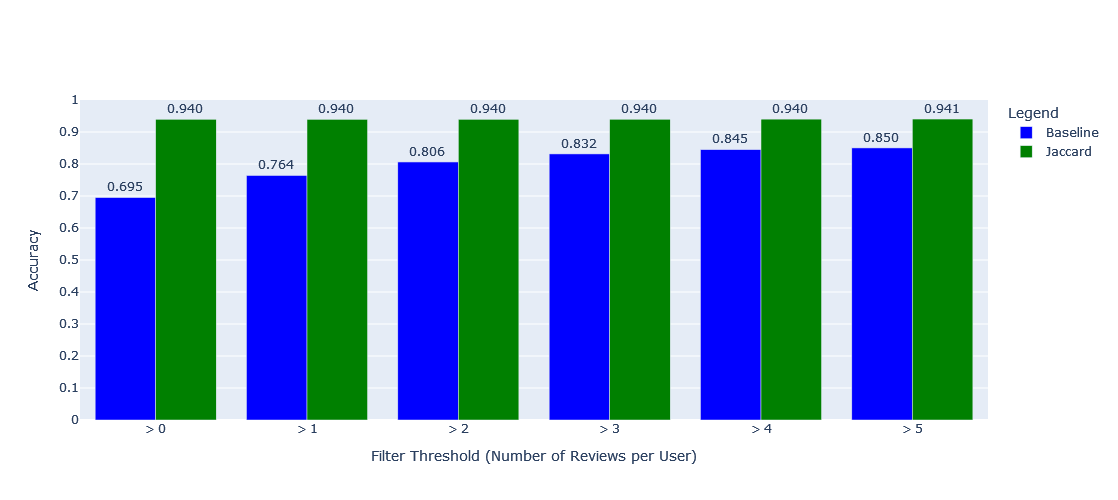

In [372]:
import plotly.graph_objects as go

# Data dictionary
data = accuracy

# Extract x-axis values and separate baseline and Jaccard data
thresholds = [int(key.split('_>')[1]) for key in data if 'baseline' in key]
baseline_values = [data[f'baseline_>{x}'] for x in thresholds]
jaccard_values = [data[f'Jaccard_>{x}'] for x in thresholds]

# Create the bar chart
fig = go.Figure()

# Add baseline bars
fig.add_trace(go.Bar(
    x=[f'> {x}' for x in thresholds], 
    y=baseline_values,
    name='Baseline',
    marker_color='blue',
    text=[f'{y:.3f}' for y in baseline_values],  # Add text for exact values
    textposition='outside'  # Position text outside the bars
))

# Add Jaccard bars
fig.add_trace(go.Bar(
    x=[f'> {x}' for x in thresholds], 
    y=jaccard_values,
    name='Jaccard',
    marker_color='green',
    text=[f'{y:.3f}' for y in jaccard_values],  # Add text for exact values
    textposition='outside'  # Position text outside the bars
))

# Customize the layout
fig.update_layout(
    xaxis_title='Filter Threshold (Number of Reviews per User)',
    yaxis_title='Accuracy',
    barmode='group',  # Group bars side-by-side
    yaxis=dict(
        range=[0, 1],  # Ensure y-axis starts at 0
        dtick=0.1  # Set y-axis intervals to 0.1
    ),
    legend=dict(title='Legend'),
    template='plotly',
    height=500,  # Increase height of the chart
)

# Show the plot
fig.show()
